## LangChain v1 Agents: Complete Guide

## Prerequisites

Make sure you have the required packages installed and Ollama running:

```bash
pip install -U langchain langchain-community langchain-core langgraph
pip install -U ddgs python-dotenv
```

Local LLM Serving with Ollama:
```bash
ollama pull qwen3
ollama pull gemma3
```

In [1]:
# pip install -U langchain langchain-community langchain-core langgraph
# pip install -U ddgs python-dotenv

---
## 1. Agent with Explicit Model Instance

Full control over model configuration by creating an explicit ChatOllama instance.

## Model Parameters Explained
- **temperature**: Controls randomness (0.0 = deterministic, 1.0 = very creative)
- **num_predict**: Maximum tokens to generate (similar to max_tokens in OpenAI)
- **top_k**: Number of highest probability tokens to consider
- **top_p**: Cumulative probability threshold for token selection
- **repeat_penalty**: Penalty for repeating tokens
- **num_ctx**: Context window size

In [2]:
from langchain_ollama import ChatOllama
from langchain.agents import create_agent
import tools

In [3]:
system_prompt = """You are a helpful AI assistant. 
Use the available tools when needed to answer questions accurately.
If you need to search for information, use the web_search tool.
Always provide clear and concise answers.
"""

In [4]:
print(tools.web_search.invoke({"query": "What is Langchain?", "num_results": 1}))

Search Results for 'What is Langchain?':


1. **What is Langchain? - Analytics Vidhya**
   This is where LangChain comes into play, a powerful open-source Python framework designed to simplify the development of LLM-powered applications.
   https://www.analyticsvidhya.com/blog/2024/06/langchain-guide/


### Your First Agent

In [5]:
model = ChatOllama(model="qwen3", base_url="http://localhost:11434")

In [6]:
agent = create_agent(model=model, tools=[tools.web_search], system_prompt=system_prompt)

In [7]:
result = agent.invoke({"messages": "What is the top 10 global news right now?"})

In [8]:
result

{'messages': [HumanMessage(content='What is the top 10 global news right now?', additional_kwargs={}, response_metadata={}, id='78d2e47c-9c61-442f-a04b-bc2d50d9f025'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-22T07:13:33.7883702Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2060956000, 'load_duration': 63019700, 'prompt_eval_count': 245, 'prompt_eval_duration': 209356700, 'eval_count': 321, 'eval_duration': 1716988700, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--c565ff28-bb94-43a8-a6e7-d142ee899539-0', tool_calls=[{'name': 'web_search', 'args': {'num_results': 10, 'query': 'top 10 global news'}, 'id': '6f0a30ef-6f8f-4c95-bc55-3704e5e25b11', 'type': 'tool_call'}], usage_metadata={'input_tokens': 245, 'output_tokens': 321, 'total_tokens': 566}),
  ToolMessage(content="Search Results for 'top 10 global news':\n\n\n1. **What are the top 10 global news stories that have made**\n   What are the t

In [9]:
# print(result['messages'][-1].content)
# result['messages'][-1].pretty_print()

In [10]:
result1 = agent.invoke(result)

In [11]:
result1

{'messages': [HumanMessage(content='What is the top 10 global news right now?', additional_kwargs={}, response_metadata={}, id='78d2e47c-9c61-442f-a04b-bc2d50d9f025'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-22T07:13:33.7883702Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2060956000, 'load_duration': 63019700, 'prompt_eval_count': 245, 'prompt_eval_duration': 209356700, 'eval_count': 321, 'eval_duration': 1716988700, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--c565ff28-bb94-43a8-a6e7-d142ee899539-0', tool_calls=[{'name': 'web_search', 'args': {'num_results': 10, 'query': 'top 10 global news'}, 'id': '6f0a30ef-6f8f-4c95-bc55-3704e5e25b11', 'type': 'tool_call'}], usage_metadata={'input_tokens': 245, 'output_tokens': 321, 'total_tokens': 566}),
  ToolMessage(content="Search Results for 'top 10 global news':\n\n\n1. **What are the top 10 global news stories that have made**\n   What are the t

### Experimenting with Different Settings

Let's compare different model configurations to see how they affect the output:

In [12]:
question = "What is the capital of France? Provide a brief explanation."

model1 = ChatOllama(model="qwen3", base_url="http://localhost:11434",
                    temperature=0,
                    top_p=1,
                    repeart_penalty=1.2,
                    num_predict=1000,
                    num_ctx=4096,
                    reasoning=True)

agent1 = create_agent(model=model1, tools=[tools.web_search], system_prompt=system_prompt)
result1 = agent1.invoke({"messages": question})

In [13]:
result1

{'messages': [HumanMessage(content='What is the capital of France? Provide a brief explanation.', additional_kwargs={}, response_metadata={}, id='768d3f7a-ccc6-4101-886f-9c4601d14378'),
  AIMessage(content='The capital of France is **Paris**. Paris is not only the political and cultural center of France but also a major global city known for its landmarks like the Eiffel Tower, Louvre Museum, and historic architecture. It serves as the seat of the French government and is a hub for art, fashion, and commerce. \n\n', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the capital of France and a brief explanation. Let me start by recalling what I know. France is a country in Europe, and I believe the capital is Paris. But wait, I should make sure that\'s correct. Maybe I should check using the web_search tool to confirm. Let me think, the function requires a query and optionally the number of results. The query here would be "capital of France". The user wants a brief 

## 2. Dynamic Model Selection (Qwen3 → Gemma3)

Cost-optimization strategy where the agent automatically switches between models based on conversation complexity.

## Selection Logic
- **< 10 messages**: Use Qwen3 (fast, efficient)
- **≥ 10 messages**: Use Gemma3 (better reasoning, longer context)

## Real-World Applications
- Customer service bots (simple queries → Qwen3, complex issues → Gemma3)
- Research assistants (quick facts → Qwen3, analysis → Gemma3)

In [14]:
# Import required modules
from langchain_ollama import ChatOllama
from langchain.agents import create_agent, AgentState
from langgraph.runtime import Runtime
import tools

# Import the middleware decorator
from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse


In [15]:
basic_model = ChatOllama(model="qwen3", base_url="http://localhost:11434", num_predict=1000)

advanced_model = ChatOllama(model="llama3.2", base_url="http://localhost:11434", num_predict=1000)

@wrap_model_call
def dynamic_model_selection(request: ModelRequest, handler) -> ModelResponse:
    message_count = len(request.state["messages"])

    if message_count<3:
        print(f"Using Qwen3 for {message_count} messages")
        request.model = basic_model

    else:
        print(f"Using llama3.2 for {message_count} messages")
        request.model = advanced_model

    return handler(request)

In [16]:
agent = create_agent(model=basic_model,
                     tools = [tools.web_search],
                     system_prompt=system_prompt,
                     middleware=[dynamic_model_selection])

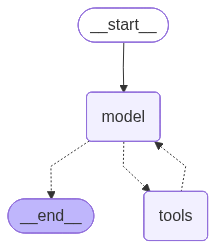

In [17]:
agent

In [18]:
def get_agent_output(messages:list):
    messages = {'messages': messages} # dict

    result = agent.invoke(messages)

    return result

In [19]:
messages = ["How are you?", "What's the weather in Mumbai today?"]
result = get_agent_output(messages)

Using Qwen3 for 2 messages
Using llama3.2 for 4 messages


In [20]:
result


{'messages': [HumanMessage(content='How are you?', additional_kwargs={}, response_metadata={}, id='f5955b31-961c-4fa7-970b-6e8598087d1e'),
  HumanMessage(content="What's the weather in Mumbai today?", additional_kwargs={}, response_metadata={}, id='2b846d2e-9d8e-4c48-9c19-bd373dfeab64'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-22T07:13:51.6046134Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3803874500, 'load_duration': 1929546000, 'prompt_eval_count': 245, 'prompt_eval_duration': 37083400, 'eval_count': 327, 'eval_duration': 1738811000, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--7de1cc24-f3df-41c6-8041-080b3f72d008-0', tool_calls=[{'name': 'web_search', 'args': {'num_results': 10, 'query': 'current weather in Mumbai'}, 'id': '21eab001-58ff-4c6d-ba41-0d2c3bf17bb1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 245, 'output_tokens': 327, 'total_tokens': 572}),
  ToolMessage(conten

### Streaming Agent Responses
#### Stream Modes
- "values": Get complete state at each step
- "updates": Get only the changes/updates
- "messages": Get only message updates

In [21]:
for chunk in agent.stream({"messages": messages}, stream_mode="values"):
    print(chunk['messages'][-1].content, end='', flush=True)

    print("\n\n------")

What's the weather in Mumbai today?

------
Using Qwen3 for 2 messages


------
Search Results for 'weather in Mumbai today':


1. **Weather Radar - Questions/Rejected/NotABug - X-Plane.Org Forum**
   Sep 26, 2024 · Hi there, Flying the 777 has been great, and the system depth and features are stunning. However, I have not been able to find much on weather radar usage in the FCOM or …
   https://forums.x-plane.org/forums/topic/317751-weather-radar/

2. **[XPGFS] NOAA GFS Weather: Real Weather For X-Plane**
   Jan 2, 2012 · XPGFS brings alive the x-plane atmosphere combining METAR reports and NOAA Weather data for the whole world. Features: - Own METAR interpretation engine. - 8 Layers of …
   https://forums.x-plane.org/files/file/15453-xpgfs-noaa-gfs-weather-real-weather-for-x-plane/

3. **Weather radar not working for me. - X-Plane.Org Forum**
   Oct 2, 2025 · WX - weather mode WX+T - Weather and turbulence, though I think this is just implemented as WX mode only TURB - not sure this 

In [22]:
for chunk in agent.stream({"messages": messages}, stream_mode="updates"):
    # print(chunk, end='', flush=True)
    if 'model' in chunk:
        chunk['model']['messages'][-1].pretty_print()
    if 'tools' in chunk:
        chunk['tools']['messages'][-1].pretty_print()
    else:
        print(chunk)
    print("\n\n------")

Using Qwen3 for 2 messages
================================== Ai Message ==================================

I'm just a helpful AI assistant, but I'm here and ready to help! 😊

For the weather in Mumbai today, let me check that for you:
Tool Calls:
  web_search (5baa36dd-d82e-4dc0-a557-7b2067c6d8c5)
 Call ID: 5baa36dd-d82e-4dc0-a557-7b2067c6d8c5
  Args:
    num_results: 5
    query: weather in Mumbai today
{'model': {'messages': [AIMessage(content="I'm just a helpful AI assistant, but I'm here and ready to help! 😊\n\nFor the weather in Mumbai today, let me check that for you:\n\n", additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-22T07:14:09.7616689Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4825303100, 'load_duration': 2264923200, 'prompt_eval_count': 245, 'prompt_eval_duration': 37077900, 'eval_count': 453, 'eval_duration': 2415884500, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--221d0f00-a4be-49c7-b39a-46657281060a-0